In [68]:
import numpy as np
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna import Trial, Study
from braindecode.models import EEGNetv4, HybridNet, EEGResNet, TCN, EEGInceptionMI
from braindecode.augmentation import AugmentedDataLoader, FTSurrogate
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.training import train, best_torch_device
from torchinfo import summary
from copy import copy, deepcopy
from prepare_data import get_frequency_dataloader, get_raw_dataloader, get_sub1_dataloader, get_time_series_dataloader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
bsz = 32

train_loader, val_loader, test_loader = get_raw_dataloader(batch_size=bsz)
train_aug_loader, _, _ = get_frequency_dataloader(batch_size=bsz)
train_sub_loader, val_sub_loader, test_sub_loader = get_sub1_dataloader(batch_size=bsz)


In [229]:
class CNN(nn.Module):
    """
    the code here reshapes back to 3D at the last step, 
    while the report structure reshapes right after
    the second Conv2d layer for better report structure.
    since the 3rd dimension is always 0 after the second Conv,
    the two structures is the same
    
    """
    def __init__(self):
        super(CNN, self).__init__()

        self.filter_nums1 = 40 # 8
        self.filter_nums2 = 80 # 40
        self.filter_nums3 = 24 # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            # (n, 8, 22, 1001)
            # shortens the time for each channel
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            # (n, 40, 1, 1001)
            # squish all 22 channels into one
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # # (n, 40, 1, 251)
            # # further compact time dimension
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            nn.Flatten(),
            nn.LazyLinear(4) # 4 output classes
            # (n, 4, 1, 1)
        )
        

    def forward(self, x):
        x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        return x

In [147]:
device = torch.device('mps')

model = CNN().to(device)
model = model.to(device)
# print(model(torch.randn((1, 22, 1000))))
summary(model, input_size=(2, 22, 1000), device='mps')

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [2, 4]                    --
├─Sequential: 1-1                        [2, 80, 1, 250]           --
│    └─Conv2d: 2-1                       [2, 40, 22, 1001]         2,600
│    └─BatchNorm2d: 2-2                  [2, 40, 22, 1001]         80
│    └─Conv2d: 2-3                       [2, 80, 1, 1001]          8,880
│    └─BatchNorm2d: 2-4                  [2, 80, 1, 1001]          160
│    └─ELU: 2-5                          [2, 80, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [2, 80, 1, 250]           --
│    └─Dropout: 2-7                      [2, 80, 1, 250]           --
├─Sequential: 1-2                        [2, 4]                    --
│    └─Conv2d: 2-8                       [2, 24, 1, 251]           3,864
│    └─BatchNorm2d: 2-9                  [2, 24, 1, 251]           48
│    └─ELU: 2-10                         [2, 24, 1, 251]           --
│    

## Train with raw data

In [148]:
from utils.training import train

raw_model = model
raw_model.to(device)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=10,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="raw.pt",
    n_epochs=150,
    show_progress_bar=True,
)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps


Epoch 0: 100%|██████████| 56/56 [00:14<00:00,  3.94batch/s, loss=1.2962]


[Epoch 0] val_acc=0.360947 train_acc=0.357907 val_loss=0.042132 train_loss=0.042552
Validation loss decreased (inf --> 0.042132).  Saving model ...


Epoch 1: 100%|██████████| 56/56 [00:14<00:00,  3.81batch/s, loss=0.9882]


[Epoch 1] val_acc=0.420118 train_acc=0.475521 val_loss=0.039105 train_loss=0.038648
Validation loss decreased (0.042132 --> 0.039105).  Saving model ...


Epoch 2: 100%|██████████| 56/56 [00:14<00:00,  3.90batch/s, loss=1.1228]


[Epoch 2] val_acc=0.511834 train_acc=0.561621 val_loss=0.036476 train_loss=0.035771
Validation loss decreased (0.039105 --> 0.036476).  Saving model ...


Epoch 3: 100%|██████████| 56/56 [00:13<00:00,  4.02batch/s, loss=0.9669]


[Epoch 3] val_acc=0.529586 train_acc=0.597074 val_loss=0.034532 train_loss=0.034450
Validation loss decreased (0.036476 --> 0.034532).  Saving model ...


Epoch 4: 100%|██████████| 56/56 [00:13<00:00,  4.01batch/s, loss=1.0812]


[Epoch 4] val_acc=0.547337 train_acc=0.630838 val_loss=0.033181 train_loss=0.033126
Validation loss decreased (0.034532 --> 0.033181).  Saving model ...


Epoch 5: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=1.3010]


[Epoch 5] val_acc=0.547337 train_acc=0.667417 val_loss=0.032551 train_loss=0.031938
Validation loss decreased (0.033181 --> 0.032551).  Saving model ...


Epoch 6: 100%|██████████| 56/56 [00:14<00:00,  3.87batch/s, loss=1.0105]


[Epoch 6] val_acc=0.568047 train_acc=0.681486 val_loss=0.033455 train_loss=0.031221
EarlyStopping counter: 1 out of 10


Epoch 7: 100%|██████████| 56/56 [00:14<00:00,  3.95batch/s, loss=1.0735]


[Epoch 7] val_acc=0.603550 train_acc=0.665166 val_loss=0.031264 train_loss=0.031057
Validation loss decreased (0.032551 --> 0.031264).  Saving model ...


Epoch 8: 100%|██████████| 56/56 [00:13<00:00,  4.02batch/s, loss=1.2291]


[Epoch 8] val_acc=0.585799 train_acc=0.703995 val_loss=0.031026 train_loss=0.029665
Validation loss decreased (0.031264 --> 0.031026).  Saving model ...


Epoch 9: 100%|██████████| 56/56 [00:14<00:00,  3.96batch/s, loss=1.0411]


[Epoch 9] val_acc=0.615385 train_acc=0.715813 val_loss=0.030348 train_loss=0.029205
Validation loss decreased (0.031026 --> 0.030348).  Saving model ...


Epoch 10: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=0.9746]


[Epoch 10] val_acc=0.594675 train_acc=0.725380 val_loss=0.030076 train_loss=0.028974
Validation loss decreased (0.030348 --> 0.030076).  Saving model ...


Epoch 11: 100%|██████████| 56/56 [00:13<00:00,  4.09batch/s, loss=0.8250]


[Epoch 11] val_acc=0.609467 train_acc=0.733258 val_loss=0.030033 train_loss=0.028804
Validation loss decreased (0.030076 --> 0.030033).  Saving model ...


Epoch 12: 100%|██████████| 56/56 [00:13<00:00,  4.10batch/s, loss=0.8764]


[Epoch 12] val_acc=0.618343 train_acc=0.750141 val_loss=0.029703 train_loss=0.027939
Validation loss decreased (0.030033 --> 0.029703).  Saving model ...


Epoch 13: 100%|██████████| 56/56 [00:13<00:00,  4.09batch/s, loss=0.8395]


[Epoch 13] val_acc=0.642012 train_acc=0.738886 val_loss=0.028687 train_loss=0.028094
Validation loss decreased (0.029703 --> 0.028687).  Saving model ...


Epoch 14: 100%|██████████| 56/56 [00:13<00:00,  4.09batch/s, loss=0.8783]


[Epoch 14] val_acc=0.644970 train_acc=0.766460 val_loss=0.027294 train_loss=0.027004
Validation loss decreased (0.028687 --> 0.027294).  Saving model ...


Epoch 15: 100%|██████████| 56/56 [00:13<00:00,  4.04batch/s, loss=0.9558]


[Epoch 15] val_acc=0.662722 train_acc=0.791784 val_loss=0.027127 train_loss=0.026639
Validation loss decreased (0.027294 --> 0.027127).  Saving model ...


Epoch 16: 100%|██████████| 56/56 [00:14<00:00,  3.94batch/s, loss=0.7138]


[Epoch 16] val_acc=0.683432 train_acc=0.783343 val_loss=0.026050 train_loss=0.026158
Validation loss decreased (0.027127 --> 0.026050).  Saving model ...


Epoch 17: 100%|██████████| 56/56 [00:13<00:00,  4.07batch/s, loss=0.8305]


[Epoch 17] val_acc=0.665680 train_acc=0.788970 val_loss=0.026947 train_loss=0.026021
EarlyStopping counter: 1 out of 10


Epoch 18: 100%|██████████| 56/56 [00:13<00:00,  4.08batch/s, loss=0.8081]


[Epoch 18] val_acc=0.695266 train_acc=0.787845 val_loss=0.025426 train_loss=0.026192
Validation loss decreased (0.026050 --> 0.025426).  Saving model ...


Epoch 19: 100%|██████████| 56/56 [00:13<00:00,  4.07batch/s, loss=0.8456]


[Epoch 19] val_acc=0.659763 train_acc=0.790658 val_loss=0.026516 train_loss=0.025599
EarlyStopping counter: 1 out of 10


Epoch 20: 100%|██████████| 56/56 [00:13<00:00,  4.07batch/s, loss=0.8213]


[Epoch 20] val_acc=0.656805 train_acc=0.803602 val_loss=0.027512 train_loss=0.025217
EarlyStopping counter: 2 out of 10


Epoch 21: 100%|██████████| 56/56 [00:14<00:00,  3.95batch/s, loss=0.7003]


[Epoch 21] val_acc=0.642012 train_acc=0.801351 val_loss=0.026371 train_loss=0.025280
EarlyStopping counter: 3 out of 10


Epoch 22: 100%|██████████| 56/56 [00:14<00:00,  3.89batch/s, loss=0.7507]


[Epoch 22] val_acc=0.683432 train_acc=0.797974 val_loss=0.025184 train_loss=0.025199
Validation loss decreased (0.025426 --> 0.025184).  Saving model ...


Epoch 23: 100%|██████████| 56/56 [00:15<00:00,  3.69batch/s, loss=0.9045]


[Epoch 23] val_acc=0.695266 train_acc=0.825549 val_loss=0.025556 train_loss=0.024777
EarlyStopping counter: 1 out of 10


Epoch 24: 100%|██████████| 56/56 [00:13<00:00,  4.03batch/s, loss=0.8697]


[Epoch 24] val_acc=0.704142 train_acc=0.821047 val_loss=0.024921 train_loss=0.024595
Validation loss decreased (0.025184 --> 0.024921).  Saving model ...


Epoch 25: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=0.8615]


[Epoch 25] val_acc=0.680473 train_acc=0.839617 val_loss=0.025780 train_loss=0.024190
EarlyStopping counter: 1 out of 10


Epoch 26: 100%|██████████| 56/56 [00:14<00:00,  3.98batch/s, loss=0.7174]


[Epoch 26] val_acc=0.713018 train_acc=0.830613 val_loss=0.024461 train_loss=0.023897
Validation loss decreased (0.024921 --> 0.024461).  Saving model ...


Epoch 27: 100%|██████████| 56/56 [00:14<00:00,  3.87batch/s, loss=0.7854]


[Epoch 27] val_acc=0.707101 train_acc=0.844119 val_loss=0.024226 train_loss=0.023867
Validation loss decreased (0.024461 --> 0.024226).  Saving model ...


Epoch 28: 100%|██████████| 56/56 [00:14<00:00,  3.88batch/s, loss=0.7453]


[Epoch 28] val_acc=0.698225 train_acc=0.836241 val_loss=0.024955 train_loss=0.024015
EarlyStopping counter: 1 out of 10


Epoch 29: 100%|██████████| 56/56 [00:13<00:00,  4.02batch/s, loss=0.7577]


[Epoch 29] val_acc=0.686391 train_acc=0.844682 val_loss=0.024586 train_loss=0.023616
EarlyStopping counter: 2 out of 10


Epoch 30: 100%|██████████| 56/56 [00:14<00:00,  3.93batch/s, loss=0.6912]


[Epoch 30] val_acc=0.671598 train_acc=0.860439 val_loss=0.025276 train_loss=0.023558
EarlyStopping counter: 3 out of 10


Epoch 31: 100%|██████████| 56/56 [00:13<00:00,  4.01batch/s, loss=0.8741]


[Epoch 31] val_acc=0.707101 train_acc=0.846370 val_loss=0.024809 train_loss=0.023546
EarlyStopping counter: 4 out of 10


Epoch 32: 100%|██████████| 56/56 [00:13<00:00,  4.03batch/s, loss=0.8259]


[Epoch 32] val_acc=0.707101 train_acc=0.867755 val_loss=0.024444 train_loss=0.023227
EarlyStopping counter: 5 out of 10


Epoch 33: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=0.7340]


[Epoch 33] val_acc=0.680473 train_acc=0.859876 val_loss=0.024419 train_loss=0.023243
EarlyStopping counter: 6 out of 10


Epoch 34: 100%|██████████| 56/56 [00:13<00:00,  4.06batch/s, loss=0.6925]


[Epoch 34] val_acc=0.704142 train_acc=0.861002 val_loss=0.023355 train_loss=0.022776
Validation loss decreased (0.024226 --> 0.023355).  Saving model ...


Epoch 35: 100%|██████████| 56/56 [00:13<00:00,  4.07batch/s, loss=0.8117]


[Epoch 35] val_acc=0.730769 train_acc=0.863253 val_loss=0.023187 train_loss=0.022862
Validation loss decreased (0.023355 --> 0.023187).  Saving model ...


Epoch 36: 100%|██████████| 56/56 [00:13<00:00,  4.01batch/s, loss=0.8041]


[Epoch 36] val_acc=0.686391 train_acc=0.858751 val_loss=0.024297 train_loss=0.023154
EarlyStopping counter: 1 out of 10


Epoch 37: 100%|██████████| 56/56 [00:13<00:00,  4.02batch/s, loss=0.7574]


[Epoch 37] val_acc=0.715976 train_acc=0.864941 val_loss=0.023676 train_loss=0.022844
EarlyStopping counter: 2 out of 10


Epoch 38: 100%|██████████| 56/56 [00:13<00:00,  4.02batch/s, loss=0.6120]


[Epoch 38] val_acc=0.713018 train_acc=0.869443 val_loss=0.023844 train_loss=0.022509
EarlyStopping counter: 3 out of 10


Epoch 39: 100%|██████████| 56/56 [00:13<00:00,  4.06batch/s, loss=0.8704]


[Epoch 39] val_acc=0.727811 train_acc=0.861564 val_loss=0.023499 train_loss=0.022759
EarlyStopping counter: 4 out of 10


Epoch 40: 100%|██████████| 56/56 [00:13<00:00,  4.06batch/s, loss=0.8094]


[Epoch 40] val_acc=0.710059 train_acc=0.861002 val_loss=0.024765 train_loss=0.022813
EarlyStopping counter: 5 out of 10


Epoch 41: 100%|██████████| 56/56 [00:13<00:00,  4.05batch/s, loss=0.6864]


[Epoch 41] val_acc=0.686391 train_acc=0.873945 val_loss=0.024490 train_loss=0.022319
EarlyStopping counter: 6 out of 10


Epoch 42: 100%|██████████| 56/56 [00:14<00:00,  3.95batch/s, loss=0.6065]


[Epoch 42] val_acc=0.704142 train_acc=0.876196 val_loss=0.024102 train_loss=0.022294
EarlyStopping counter: 7 out of 10


Epoch 43: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=0.7617]


[Epoch 43] val_acc=0.715976 train_acc=0.861564 val_loss=0.023723 train_loss=0.022810
EarlyStopping counter: 8 out of 10


Epoch 44: 100%|██████████| 56/56 [00:14<00:00,  4.00batch/s, loss=0.8461]


[Epoch 44] val_acc=0.677515 train_acc=0.874508 val_loss=0.024730 train_loss=0.022134
EarlyStopping counter: 9 out of 10


Epoch 45: 100%|██████████| 56/56 [00:13<00:00,  4.04batch/s, loss=0.6945]


[Epoch 45] val_acc=0.701183 train_acc=0.875070 val_loss=0.023921 train_loss=0.022126
EarlyStopping counter: 10 out of 10
Early stopping.


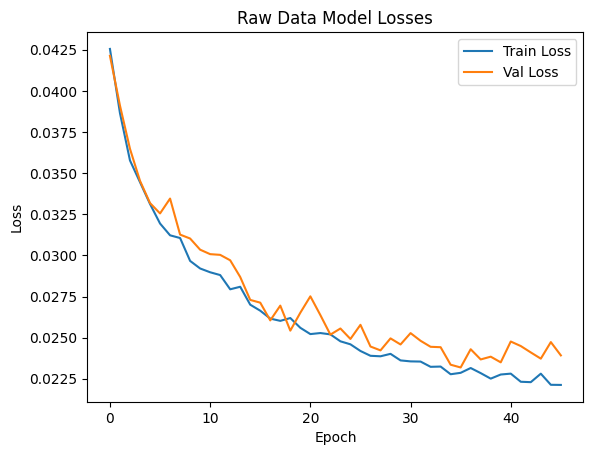

In [ ]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

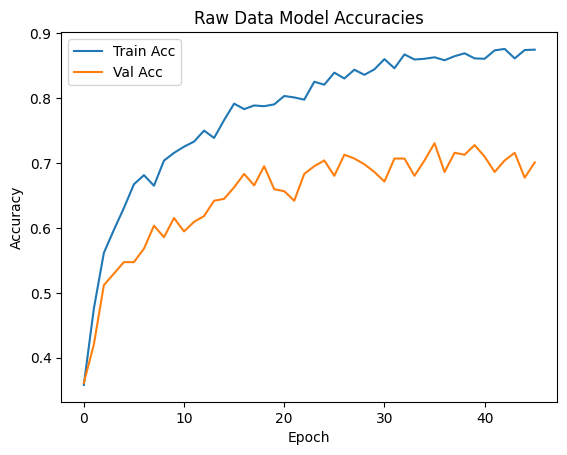

In [150]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [154]:
# Load best model and test
raw_model = torch.load("models/cnn/raw.pt")
raw_model.to(device)
raw_model.eval()
summary(raw_model, input_size=(1, 22, 1000), device='mps')

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Sequential: 1-1                        [1, 80, 1, 250]           --
│    └─Conv2d: 2-1                       [1, 40, 22, 1001]         2,600
│    └─BatchNorm2d: 2-2                  [1, 40, 22, 1001]         80
│    └─Conv2d: 2-3                       [1, 80, 1, 1001]          8,880
│    └─BatchNorm2d: 2-4                  [1, 80, 1, 1001]          160
│    └─ELU: 2-5                          [1, 80, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [1, 80, 1, 250]           --
│    └─Dropout: 2-7                      [1, 80, 1, 250]           --
├─Sequential: 1-2                        [1, 4]                    --
│    └─Conv2d: 2-8                       [1, 24, 1, 251]           3,864
│    └─BatchNorm2d: 2-9                  [1, 24, 1, 251]           48
│    └─ELU: 2-10                         [1, 24, 1, 251]           --
│    

In [155]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.7201


In [156]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.7200


## Train with augmented data with FT surrogate

In [239]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.filter_nums1 = 40 # 8
        self.filter_nums2 = 48 # 40
        self.filter_nums3 = 64 # 12
        self.filter_nums4 = 96
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            # (n, 8, 22, 1001)
            # shortens the time for each channel
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            # (n, 40, 1, 1001)
            # squish all 22 channels into one
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 12), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # # (n, 40, 1, 251)
            # # further compact time dimension
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.filter_nums3, self.filter_nums4, kernel_size=(1, 4), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # # (n, 40, 1, 251)
            # # further compact time dimension
            nn.BatchNorm2d(self.filter_nums4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            nn.Flatten(),
            nn.LazyLinear(4) # 4 output classes
            # (n, 4, 1, 1)
        )
        

    def forward(self, x):
        x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        return x

In [230]:
device = torch.device('mps')

model = CNN().to(device)
model = model.to(device)
print(model(torch.randn(1, 22, 1000)).shape)
summary(model, input_size=(1, 22, 1000), device='mps')

torch.Size([1, 4])


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Sequential: 1-1                        [1, 80, 1, 250]           --
│    └─Conv2d: 2-1                       [1, 40, 22, 1001]         2,600
│    └─BatchNorm2d: 2-2                  [1, 40, 22, 1001]         80
│    └─Conv2d: 2-3                       [1, 80, 1, 1001]          8,880
│    └─BatchNorm2d: 2-4                  [1, 80, 1, 1001]          160
│    └─ELU: 2-5                          [1, 80, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [1, 80, 1, 250]           --
│    └─Dropout: 2-7                      [1, 80, 1, 250]           --
├─Sequential: 1-2                        [1, 4]                    --
│    └─Conv2d: 2-8                       [1, 24, 1, 251]           3,864
│    └─BatchNorm2d: 2-9                  [1, 24, 1, 251]           48
│    └─ELU: 2-10                         [1, 24, 1, 251]           --
│    

In [231]:
from utils.training import train

aug_model = model
aug_model.to(device)

optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_aug_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=aug_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="aug.pt",
    n_epochs=150,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 56/56 [00:15<00:00,  3.72batch/s, loss=1.3771]


[Epoch 0] val_acc=0.313609 train_acc=0.278559 val_loss=0.044340 train_loss=0.044342
Validation loss decreased (inf --> 0.044340).  Saving model ...


Epoch 1: 100%|██████████| 56/56 [00:14<00:00,  3.92batch/s, loss=1.3883]


[Epoch 1] val_acc=0.357988 train_acc=0.324142 val_loss=0.043982 train_loss=0.043380
Validation loss decreased (0.044340 --> 0.043982).  Saving model ...


Epoch 2: 100%|██████████| 56/56 [00:14<00:00,  3.97batch/s, loss=1.2992]


[Epoch 2] val_acc=0.349112 train_acc=0.328644 val_loss=0.043078 train_loss=0.043107
Validation loss decreased (0.043982 --> 0.043078).  Saving model ...


Epoch 3: 100%|██████████| 56/56 [00:15<00:00,  3.66batch/s, loss=1.4127]


[Epoch 3] val_acc=0.396450 train_acc=0.375352 val_loss=0.041710 train_loss=0.042390
Validation loss decreased (0.043078 --> 0.041710).  Saving model ...


Epoch 4: 100%|██████████| 56/56 [00:15<00:00,  3.59batch/s, loss=1.3219]


[Epoch 4] val_acc=0.387574 train_acc=0.386044 val_loss=0.041243 train_loss=0.042060
Validation loss decreased (0.041710 --> 0.041243).  Saving model ...


Epoch 5: 100%|██████████| 56/56 [00:13<00:00,  4.07batch/s, loss=1.2051]


[Epoch 5] val_acc=0.458580 train_acc=0.413618 val_loss=0.038923 train_loss=0.041284
Validation loss decreased (0.041243 --> 0.038923).  Saving model ...


Epoch 6: 100%|██████████| 56/56 [00:14<00:00,  3.99batch/s, loss=1.3808]


[Epoch 6] val_acc=0.476331 train_acc=0.440630 val_loss=0.037491 train_loss=0.040571
Validation loss decreased (0.038923 --> 0.037491).  Saving model ...


Epoch 7: 100%|██████████| 56/56 [00:13<00:00,  4.08batch/s, loss=1.4242]


[Epoch 7] val_acc=0.497041 train_acc=0.453573 val_loss=0.036359 train_loss=0.039919
Validation loss decreased (0.037491 --> 0.036359).  Saving model ...


Epoch 8: 100%|██████████| 56/56 [00:13<00:00,  4.00batch/s, loss=1.3831]


[Epoch 8] val_acc=0.526627 train_acc=0.476646 val_loss=0.035066 train_loss=0.039334
Validation loss decreased (0.036359 --> 0.035066).  Saving model ...


Epoch 9: 100%|██████████| 56/56 [00:13<00:00,  4.06batch/s, loss=1.1963]


[Epoch 9] val_acc=0.562130 train_acc=0.486775 val_loss=0.034349 train_loss=0.039103
Validation loss decreased (0.035066 --> 0.034349).  Saving model ...


Epoch 10: 100%|██████████| 56/56 [00:14<00:00,  3.86batch/s, loss=1.1562]


[Epoch 10] val_acc=0.568047 train_acc=0.502532 val_loss=0.033844 train_loss=0.038220
Validation loss decreased (0.034349 --> 0.033844).  Saving model ...


Epoch 11: 100%|██████████| 56/56 [00:14<00:00,  3.75batch/s, loss=1.2259]


[Epoch 11] val_acc=0.553254 train_acc=0.508160 val_loss=0.033706 train_loss=0.038384
Validation loss decreased (0.033844 --> 0.033706).  Saving model ...


Epoch 12: 100%|██████████| 56/56 [00:14<00:00,  3.95batch/s, loss=1.2233]


[Epoch 12] val_acc=0.556213 train_acc=0.514913 val_loss=0.033565 train_loss=0.037693
Validation loss decreased (0.033706 --> 0.033565).  Saving model ...


Epoch 13: 100%|██████████| 56/56 [00:14<00:00,  3.89batch/s, loss=1.0532]


[Epoch 13] val_acc=0.594675 train_acc=0.522791 val_loss=0.032243 train_loss=0.037311
Validation loss decreased (0.033565 --> 0.032243).  Saving model ...


Epoch 14: 100%|██████████| 56/56 [00:14<00:00,  3.95batch/s, loss=1.1789]


[Epoch 14] val_acc=0.573964 train_acc=0.522791 val_loss=0.032134 train_loss=0.037470
Validation loss decreased (0.032243 --> 0.032134).  Saving model ...


Epoch 15: 100%|██████████| 56/56 [00:14<00:00,  3.87batch/s, loss=1.1736]


[Epoch 15] val_acc=0.565089 train_acc=0.536297 val_loss=0.031736 train_loss=0.036976
Validation loss decreased (0.032134 --> 0.031736).  Saving model ...


Epoch 16: 100%|██████████| 56/56 [00:14<00:00,  3.93batch/s, loss=0.9269]


[Epoch 16] val_acc=0.579882 train_acc=0.528981 val_loss=0.031869 train_loss=0.037010
EarlyStopping counter: 1 out of 30


Epoch 17: 100%|██████████| 56/56 [00:14<00:00,  3.84batch/s, loss=1.3026]


[Epoch 17] val_acc=0.588757 train_acc=0.544176 val_loss=0.032087 train_loss=0.036549
EarlyStopping counter: 2 out of 30


Epoch 18: 100%|██████████| 56/56 [00:14<00:00,  3.86batch/s, loss=1.0703]


[Epoch 18] val_acc=0.609467 train_acc=0.554868 val_loss=0.031125 train_loss=0.036601
Validation loss decreased (0.031736 --> 0.031125).  Saving model ...


Epoch 19: 100%|██████████| 56/56 [00:14<00:00,  3.81batch/s, loss=1.2854]


[Epoch 19] val_acc=0.677515 train_acc=0.545864 val_loss=0.029973 train_loss=0.036415
Validation loss decreased (0.031125 --> 0.029973).  Saving model ...


Epoch 20: 100%|██████████| 56/56 [00:14<00:00,  3.82batch/s, loss=1.2847]


[Epoch 20] val_acc=0.618343 train_acc=0.566123 val_loss=0.031201 train_loss=0.035382
EarlyStopping counter: 1 out of 30


Epoch 21: 100%|██████████| 56/56 [00:14<00:00,  3.75batch/s, loss=1.1478]


[Epoch 21] val_acc=0.636095 train_acc=0.567811 val_loss=0.030047 train_loss=0.035634
EarlyStopping counter: 2 out of 30


Epoch 22: 100%|██████████| 56/56 [00:16<00:00,  3.32batch/s, loss=1.0662]


[Epoch 22] val_acc=0.642012 train_acc=0.569499 val_loss=0.029667 train_loss=0.035415
Validation loss decreased (0.029973 --> 0.029667).  Saving model ...


Epoch 23: 100%|██████████| 56/56 [00:17<00:00,  3.18batch/s, loss=1.0366]


[Epoch 23] val_acc=0.636095 train_acc=0.558244 val_loss=0.029748 train_loss=0.035647
EarlyStopping counter: 1 out of 30


Epoch 24: 100%|██████████| 56/56 [00:15<00:00,  3.64batch/s, loss=1.3067]


[Epoch 24] val_acc=0.647929 train_acc=0.572313 val_loss=0.029819 train_loss=0.035568
EarlyStopping counter: 2 out of 30


Epoch 25: 100%|██████████| 56/56 [00:14<00:00,  3.76batch/s, loss=0.9825]


[Epoch 25] val_acc=0.665680 train_acc=0.590884 val_loss=0.028893 train_loss=0.034787
Validation loss decreased (0.029667 --> 0.028893).  Saving model ...


Epoch 26: 100%|██████████| 56/56 [00:14<00:00,  3.74batch/s, loss=1.0888]


[Epoch 26] val_acc=0.627219 train_acc=0.606640 val_loss=0.029237 train_loss=0.034339
EarlyStopping counter: 1 out of 30


Epoch 27: 100%|██████████| 56/56 [00:15<00:00,  3.71batch/s, loss=1.0169]


[Epoch 27] val_acc=0.642012 train_acc=0.584131 val_loss=0.030924 train_loss=0.034854
EarlyStopping counter: 2 out of 30


Epoch 28: 100%|██████████| 56/56 [00:15<00:00,  3.63batch/s, loss=1.0823]


[Epoch 28] val_acc=0.662722 train_acc=0.584131 val_loss=0.028517 train_loss=0.034934
Validation loss decreased (0.028893 --> 0.028517).  Saving model ...


Epoch 29: 100%|██████████| 56/56 [00:15<00:00,  3.55batch/s, loss=1.2243]


[Epoch 29] val_acc=0.659763 train_acc=0.585256 val_loss=0.028962 train_loss=0.034499
EarlyStopping counter: 1 out of 30


Epoch 30: 100%|██████████| 56/56 [00:15<00:00,  3.64batch/s, loss=1.0340]


[Epoch 30] val_acc=0.653846 train_acc=0.601576 val_loss=0.029580 train_loss=0.034388
EarlyStopping counter: 2 out of 30


Epoch 31: 100%|██████████| 56/56 [00:15<00:00,  3.61batch/s, loss=0.9344]


[Epoch 31] val_acc=0.636095 train_acc=0.624086 val_loss=0.028583 train_loss=0.033609
EarlyStopping counter: 3 out of 30


Epoch 32: 100%|██████████| 56/56 [00:15<00:00,  3.69batch/s, loss=1.1342]


[Epoch 32] val_acc=0.662722 train_acc=0.612831 val_loss=0.028589 train_loss=0.033783
EarlyStopping counter: 4 out of 30


Epoch 33: 100%|██████████| 56/56 [00:15<00:00,  3.67batch/s, loss=0.9397]


[Epoch 33] val_acc=0.647929 train_acc=0.607766 val_loss=0.027794 train_loss=0.033900
Validation loss decreased (0.028517 --> 0.027794).  Saving model ...


Epoch 34: 100%|██████████| 56/56 [00:15<00:00,  3.67batch/s, loss=1.1241]


[Epoch 34] val_acc=0.680473 train_acc=0.615644 val_loss=0.027564 train_loss=0.033572
Validation loss decreased (0.027794 --> 0.027564).  Saving model ...


Epoch 35: 100%|██████████| 56/56 [00:15<00:00,  3.60batch/s, loss=1.1812]


[Epoch 35] val_acc=0.668639 train_acc=0.595948 val_loss=0.027994 train_loss=0.033967
EarlyStopping counter: 1 out of 30


Epoch 36: 100%|██████████| 56/56 [00:15<00:00,  3.55batch/s, loss=1.2429]


[Epoch 36] val_acc=0.671598 train_acc=0.608329 val_loss=0.027191 train_loss=0.033565
Validation loss decreased (0.027564 --> 0.027191).  Saving model ...


Epoch 37: 100%|██████████| 56/56 [00:16<00:00,  3.43batch/s, loss=1.0744]


[Epoch 37] val_acc=0.647929 train_acc=0.648284 val_loss=0.028403 train_loss=0.032961
EarlyStopping counter: 1 out of 30


Epoch 38: 100%|██████████| 56/56 [00:17<00:00,  3.29batch/s, loss=1.1261]


[Epoch 38] val_acc=0.644970 train_acc=0.615082 val_loss=0.029374 train_loss=0.033852
EarlyStopping counter: 2 out of 30


Epoch 39: 100%|██████████| 56/56 [00:20<00:00,  2.71batch/s, loss=1.1171]


[Epoch 39] val_acc=0.668639 train_acc=0.624648 val_loss=0.027337 train_loss=0.033366
EarlyStopping counter: 3 out of 30


Epoch 40: 100%|██████████| 56/56 [00:17<00:00,  3.18batch/s, loss=1.0793]


[Epoch 40] val_acc=0.674556 train_acc=0.645470 val_loss=0.027765 train_loss=0.032900
EarlyStopping counter: 4 out of 30


Epoch 41: 100%|██████████| 56/56 [00:18<00:00,  3.10batch/s, loss=0.9075]


[Epoch 41] val_acc=0.656805 train_acc=0.626337 val_loss=0.028182 train_loss=0.033440
EarlyStopping counter: 5 out of 30


Epoch 42: 100%|██████████| 56/56 [00:18<00:00,  3.04batch/s, loss=0.9072]


[Epoch 42] val_acc=0.692308 train_acc=0.628588 val_loss=0.027046 train_loss=0.033180
Validation loss decreased (0.027191 --> 0.027046).  Saving model ...


Epoch 43: 100%|██████████| 56/56 [00:17<00:00,  3.12batch/s, loss=0.9289]


[Epoch 43] val_acc=0.710059 train_acc=0.649409 val_loss=0.026559 train_loss=0.032559
Validation loss decreased (0.027046 --> 0.026559).  Saving model ...


Epoch 44: 100%|██████████| 56/56 [00:17<00:00,  3.16batch/s, loss=0.7880]


[Epoch 44] val_acc=0.680473 train_acc=0.648846 val_loss=0.027422 train_loss=0.032362
EarlyStopping counter: 1 out of 30


Epoch 45: 100%|██████████| 56/56 [00:17<00:00,  3.21batch/s, loss=0.9857]


[Epoch 45] val_acc=0.707101 train_acc=0.629713 val_loss=0.027068 train_loss=0.033220
EarlyStopping counter: 2 out of 30


Epoch 46: 100%|██████████| 56/56 [00:17<00:00,  3.24batch/s, loss=0.8029]


[Epoch 46] val_acc=0.692308 train_acc=0.640968 val_loss=0.026721 train_loss=0.032161
EarlyStopping counter: 3 out of 30


Epoch 47: 100%|██████████| 56/56 [00:17<00:00,  3.14batch/s, loss=1.0260]


[Epoch 47] val_acc=0.701183 train_acc=0.650535 val_loss=0.026647 train_loss=0.032245
EarlyStopping counter: 4 out of 30


Epoch 48: 100%|██████████| 56/56 [00:18<00:00,  3.08batch/s, loss=0.9828]


[Epoch 48] val_acc=0.680473 train_acc=0.647721 val_loss=0.026913 train_loss=0.032564
EarlyStopping counter: 5 out of 30


Epoch 49: 100%|██████████| 56/56 [00:17<00:00,  3.19batch/s, loss=0.9266]


[Epoch 49] val_acc=0.650888 train_acc=0.644344 val_loss=0.027568 train_loss=0.032144
EarlyStopping counter: 6 out of 30


Epoch 50: 100%|██████████| 56/56 [00:17<00:00,  3.24batch/s, loss=0.9792]


[Epoch 50] val_acc=0.695266 train_acc=0.642093 val_loss=0.026565 train_loss=0.032291
EarlyStopping counter: 7 out of 30


Epoch 51: 100%|██████████| 56/56 [00:17<00:00,  3.20batch/s, loss=0.9434]


[Epoch 51] val_acc=0.659763 train_acc=0.643219 val_loss=0.027749 train_loss=0.032590
EarlyStopping counter: 8 out of 30


Epoch 52: 100%|██████████| 56/56 [00:17<00:00,  3.18batch/s, loss=0.8666]


[Epoch 52] val_acc=0.704142 train_acc=0.648284 val_loss=0.027311 train_loss=0.032178
EarlyStopping counter: 9 out of 30


Epoch 53: 100%|██████████| 56/56 [00:18<00:00,  3.10batch/s, loss=1.0065]


[Epoch 53] val_acc=0.668639 train_acc=0.647721 val_loss=0.027337 train_loss=0.032632
EarlyStopping counter: 10 out of 30


Epoch 54: 100%|██████████| 56/56 [00:19<00:00,  2.91batch/s, loss=1.3519]


[Epoch 54] val_acc=0.662722 train_acc=0.657850 val_loss=0.028031 train_loss=0.032071
EarlyStopping counter: 11 out of 30


Epoch 55: 100%|██████████| 56/56 [00:17<00:00,  3.21batch/s, loss=1.2372]


[Epoch 55] val_acc=0.695266 train_acc=0.666292 val_loss=0.026505 train_loss=0.031518
Validation loss decreased (0.026559 --> 0.026505).  Saving model ...


Epoch 56: 100%|██████████| 56/56 [00:17<00:00,  3.20batch/s, loss=0.8436]


[Epoch 56] val_acc=0.692308 train_acc=0.669105 val_loss=0.026012 train_loss=0.031867
Validation loss decreased (0.026505 --> 0.026012).  Saving model ...


Epoch 57: 100%|██████████| 56/56 [00:17<00:00,  3.22batch/s, loss=1.0281]


[Epoch 57] val_acc=0.665680 train_acc=0.654474 val_loss=0.027448 train_loss=0.031911
EarlyStopping counter: 1 out of 30


Epoch 58: 100%|██████████| 56/56 [00:18<00:00,  3.11batch/s, loss=1.2233]


[Epoch 58] val_acc=0.701183 train_acc=0.666292 val_loss=0.026378 train_loss=0.031670
EarlyStopping counter: 2 out of 30


Epoch 59: 100%|██████████| 56/56 [00:18<00:00,  3.07batch/s, loss=0.8844]


[Epoch 59] val_acc=0.683432 train_acc=0.655599 val_loss=0.026976 train_loss=0.032306
EarlyStopping counter: 3 out of 30


Epoch 60: 100%|██████████| 56/56 [00:17<00:00,  3.23batch/s, loss=0.8790]


[Epoch 60] val_acc=0.686391 train_acc=0.671919 val_loss=0.026028 train_loss=0.031610
EarlyStopping counter: 4 out of 30


Epoch 61: 100%|██████████| 56/56 [00:17<00:00,  3.22batch/s, loss=1.0681]


[Epoch 61] val_acc=0.692308 train_acc=0.667980 val_loss=0.026194 train_loss=0.031647
EarlyStopping counter: 5 out of 30


Epoch 62: 100%|██████████| 56/56 [00:19<00:00,  2.90batch/s, loss=0.9775]


[Epoch 62] val_acc=0.701183 train_acc=0.680923 val_loss=0.026009 train_loss=0.030863
Validation loss decreased (0.026012 --> 0.026009).  Saving model ...


Epoch 63: 100%|██████████| 56/56 [00:18<00:00,  3.10batch/s, loss=0.9961]


[Epoch 63] val_acc=0.707101 train_acc=0.687676 val_loss=0.025659 train_loss=0.030935
Validation loss decreased (0.026009 --> 0.025659).  Saving model ...


Epoch 64: 100%|██████████| 56/56 [00:18<00:00,  3.06batch/s, loss=0.9939]


[Epoch 64] val_acc=0.710059 train_acc=0.689364 val_loss=0.025585 train_loss=0.031130
Validation loss decreased (0.025659 --> 0.025585).  Saving model ...


Epoch 65: 100%|██████████| 56/56 [00:19<00:00,  2.90batch/s, loss=0.8023]


[Epoch 65] val_acc=0.713018 train_acc=0.697805 val_loss=0.025781 train_loss=0.030312
EarlyStopping counter: 1 out of 30


Epoch 66: 100%|██████████| 56/56 [00:21<00:00,  2.62batch/s, loss=1.0382]


[Epoch 66] val_acc=0.680473 train_acc=0.709623 val_loss=0.025752 train_loss=0.030169
EarlyStopping counter: 2 out of 30


Epoch 67: 100%|██████████| 56/56 [00:21<00:00,  2.66batch/s, loss=1.0534]


[Epoch 67] val_acc=0.671598 train_acc=0.698931 val_loss=0.026123 train_loss=0.030524
EarlyStopping counter: 3 out of 30


Epoch 68: 100%|██████████| 56/56 [00:19<00:00,  2.91batch/s, loss=1.2227]


[Epoch 68] val_acc=0.715976 train_acc=0.697805 val_loss=0.026249 train_loss=0.030398
EarlyStopping counter: 4 out of 30


Epoch 69: 100%|██████████| 56/56 [00:18<00:00,  3.07batch/s, loss=1.0715]


[Epoch 69] val_acc=0.674556 train_acc=0.706246 val_loss=0.025993 train_loss=0.030121
EarlyStopping counter: 5 out of 30


Epoch 70: 100%|██████████| 56/56 [00:18<00:00,  3.06batch/s, loss=1.0162]


[Epoch 70] val_acc=0.704142 train_acc=0.690490 val_loss=0.025243 train_loss=0.030504
Validation loss decreased (0.025585 --> 0.025243).  Saving model ...


Epoch 71: 100%|██████████| 56/56 [00:17<00:00,  3.11batch/s, loss=0.8809]


[Epoch 71] val_acc=0.674556 train_acc=0.701182 val_loss=0.026598 train_loss=0.030320
EarlyStopping counter: 1 out of 30


Epoch 72: 100%|██████████| 56/56 [00:19<00:00,  2.86batch/s, loss=0.9613]


[Epoch 72] val_acc=0.721893 train_acc=0.696117 val_loss=0.026014 train_loss=0.030503
EarlyStopping counter: 2 out of 30


Epoch 73: 100%|██████████| 56/56 [00:17<00:00,  3.12batch/s, loss=1.1039]


[Epoch 73] val_acc=0.674556 train_acc=0.714688 val_loss=0.026056 train_loss=0.030060
EarlyStopping counter: 3 out of 30


Epoch 74: 100%|██████████| 56/56 [00:17<00:00,  3.17batch/s, loss=0.9627]


[Epoch 74] val_acc=0.689349 train_acc=0.684299 val_loss=0.025788 train_loss=0.030456
EarlyStopping counter: 4 out of 30


Epoch 75: 100%|██████████| 56/56 [00:19<00:00,  2.87batch/s, loss=0.9950]


[Epoch 75] val_acc=0.733728 train_acc=0.698931 val_loss=0.025347 train_loss=0.030604
EarlyStopping counter: 5 out of 30


Epoch 76: 100%|██████████| 56/56 [00:18<00:00,  3.05batch/s, loss=0.8156]


[Epoch 76] val_acc=0.707101 train_acc=0.700619 val_loss=0.025415 train_loss=0.030249
EarlyStopping counter: 6 out of 30


Epoch 77: 100%|██████████| 56/56 [00:17<00:00,  3.24batch/s, loss=1.0073]


[Epoch 77] val_acc=0.718935 train_acc=0.724254 val_loss=0.025033 train_loss=0.029277
Validation loss decreased (0.025243 --> 0.025033).  Saving model ...


Epoch 78: 100%|██████████| 56/56 [00:17<00:00,  3.29batch/s, loss=1.0132]


[Epoch 78] val_acc=0.715976 train_acc=0.696680 val_loss=0.025391 train_loss=0.030067
EarlyStopping counter: 1 out of 30


Epoch 79: 100%|██████████| 56/56 [00:17<00:00,  3.11batch/s, loss=0.9484]


[Epoch 79] val_acc=0.710059 train_acc=0.708497 val_loss=0.025265 train_loss=0.029727
EarlyStopping counter: 2 out of 30


Epoch 80: 100%|██████████| 56/56 [00:17<00:00,  3.14batch/s, loss=0.9301]


[Epoch 80] val_acc=0.713018 train_acc=0.711874 val_loss=0.025335 train_loss=0.029603
EarlyStopping counter: 3 out of 30


Epoch 81: 100%|██████████| 56/56 [00:20<00:00,  2.77batch/s, loss=1.1736]


[Epoch 81] val_acc=0.686391 train_acc=0.711874 val_loss=0.026162 train_loss=0.030037
EarlyStopping counter: 4 out of 30


Epoch 82: 100%|██████████| 56/56 [00:20<00:00,  2.71batch/s, loss=1.0676]


[Epoch 82] val_acc=0.713018 train_acc=0.705684 val_loss=0.025087 train_loss=0.029932
EarlyStopping counter: 5 out of 30


Epoch 83: 100%|██████████| 56/56 [00:21<00:00,  2.65batch/s, loss=0.8738]


[Epoch 83] val_acc=0.695266 train_acc=0.709060 val_loss=0.025221 train_loss=0.030212
EarlyStopping counter: 6 out of 30


Epoch 84: 100%|██████████| 56/56 [00:19<00:00,  2.88batch/s, loss=1.0015]


[Epoch 84] val_acc=0.713018 train_acc=0.719752 val_loss=0.024765 train_loss=0.029106
Validation loss decreased (0.025033 --> 0.024765).  Saving model ...


Epoch 85: 100%|██████████| 56/56 [00:17<00:00,  3.16batch/s, loss=0.9944]


[Epoch 85] val_acc=0.710059 train_acc=0.714688 val_loss=0.024935 train_loss=0.029472
EarlyStopping counter: 1 out of 30


Epoch 86: 100%|██████████| 56/56 [00:18<00:00,  3.10batch/s, loss=1.0073]


[Epoch 86] val_acc=0.710059 train_acc=0.718627 val_loss=0.024864 train_loss=0.030018
EarlyStopping counter: 2 out of 30


Epoch 87: 100%|██████████| 56/56 [00:18<00:00,  3.02batch/s, loss=0.9616]


[Epoch 87] val_acc=0.698225 train_acc=0.716376 val_loss=0.024824 train_loss=0.029398
EarlyStopping counter: 3 out of 30


Epoch 88: 100%|██████████| 56/56 [00:22<00:00,  2.46batch/s, loss=1.1505]


[Epoch 88] val_acc=0.707101 train_acc=0.712999 val_loss=0.024692 train_loss=0.029776
Validation loss decreased (0.024765 --> 0.024692).  Saving model ...


Epoch 89: 100%|██████████| 56/56 [00:18<00:00,  3.06batch/s, loss=1.0413]


[Epoch 89] val_acc=0.721893 train_acc=0.718064 val_loss=0.024747 train_loss=0.029383
EarlyStopping counter: 1 out of 30


Epoch 90: 100%|██████████| 56/56 [00:18<00:00,  3.03batch/s, loss=0.9221]


[Epoch 90] val_acc=0.704142 train_acc=0.726505 val_loss=0.024846 train_loss=0.029209
EarlyStopping counter: 2 out of 30


Epoch 91: 100%|██████████| 56/56 [00:17<00:00,  3.21batch/s, loss=1.0288]


[Epoch 91] val_acc=0.713018 train_acc=0.733821 val_loss=0.025004 train_loss=0.028898
EarlyStopping counter: 3 out of 30


Epoch 92: 100%|██████████| 56/56 [00:17<00:00,  3.20batch/s, loss=0.9717]


[Epoch 92] val_acc=0.701183 train_acc=0.724254 val_loss=0.024902 train_loss=0.029584
EarlyStopping counter: 4 out of 30


Epoch 93: 100%|██████████| 56/56 [00:19<00:00,  2.92batch/s, loss=0.8260]


[Epoch 93] val_acc=0.715976 train_acc=0.731007 val_loss=0.024712 train_loss=0.028876
EarlyStopping counter: 5 out of 30


Epoch 94: 100%|██████████| 56/56 [00:18<00:00,  3.07batch/s, loss=0.7920]


[Epoch 94] val_acc=0.724852 train_acc=0.731007 val_loss=0.024524 train_loss=0.029326
Validation loss decreased (0.024692 --> 0.024524).  Saving model ...


Epoch 95: 100%|██████████| 56/56 [00:18<00:00,  2.96batch/s, loss=0.7550]


[Epoch 95] val_acc=0.718935 train_acc=0.720315 val_loss=0.024623 train_loss=0.028842
EarlyStopping counter: 1 out of 30


Epoch 96: 100%|██████████| 56/56 [00:21<00:00,  2.64batch/s, loss=1.2691]


[Epoch 96] val_acc=0.718935 train_acc=0.733821 val_loss=0.024625 train_loss=0.028455
EarlyStopping counter: 2 out of 30


Epoch 97: 100%|██████████| 56/56 [00:22<00:00,  2.54batch/s, loss=0.8013]


[Epoch 97] val_acc=0.710059 train_acc=0.731007 val_loss=0.024578 train_loss=0.029231
EarlyStopping counter: 3 out of 30


Epoch 98: 100%|██████████| 56/56 [00:22<00:00,  2.49batch/s, loss=0.9939]


[Epoch 98] val_acc=0.721893 train_acc=0.737198 val_loss=0.024693 train_loss=0.028683
EarlyStopping counter: 4 out of 30


Epoch 99: 100%|██████████| 56/56 [00:18<00:00,  3.05batch/s, loss=0.8553]


[Epoch 99] val_acc=0.713018 train_acc=0.743388 val_loss=0.024477 train_loss=0.028414
Validation loss decreased (0.024524 --> 0.024477).  Saving model ...


Epoch 100: 100%|██████████| 56/56 [00:20<00:00,  2.73batch/s, loss=0.9465]


[Epoch 100] val_acc=0.713018 train_acc=0.731007 val_loss=0.024381 train_loss=0.028799
Validation loss decreased (0.024477 --> 0.024381).  Saving model ...


Epoch 101: 100%|██████████| 56/56 [00:21<00:00,  2.63batch/s, loss=0.8484]


[Epoch 101] val_acc=0.724852 train_acc=0.737198 val_loss=0.024533 train_loss=0.028622
EarlyStopping counter: 1 out of 30


Epoch 102: 100%|██████████| 56/56 [00:22<00:00,  2.50batch/s, loss=0.8615]


[Epoch 102] val_acc=0.710059 train_acc=0.756331 val_loss=0.024368 train_loss=0.028599
Validation loss decreased (0.024381 --> 0.024368).  Saving model ...


Epoch 103: 100%|██████████| 56/56 [00:18<00:00,  2.97batch/s, loss=0.8469]


[Epoch 103] val_acc=0.721893 train_acc=0.735509 val_loss=0.024616 train_loss=0.029034
EarlyStopping counter: 1 out of 30


Epoch 104: 100%|██████████| 56/56 [00:19<00:00,  2.88batch/s, loss=0.9181]


[Epoch 104] val_acc=0.715976 train_acc=0.749015 val_loss=0.024509 train_loss=0.028568
EarlyStopping counter: 2 out of 30


Epoch 105: 100%|██████████| 56/56 [00:18<00:00,  3.03batch/s, loss=0.8260]


[Epoch 105] val_acc=0.718935 train_acc=0.726505 val_loss=0.024658 train_loss=0.028749
EarlyStopping counter: 3 out of 30


Epoch 106: 100%|██████████| 56/56 [00:18<00:00,  3.04batch/s, loss=1.0885]


[Epoch 106] val_acc=0.715976 train_acc=0.731007 val_loss=0.024390 train_loss=0.028877
EarlyStopping counter: 4 out of 30


Epoch 107: 100%|██████████| 56/56 [00:18<00:00,  2.97batch/s, loss=0.9323]


[Epoch 107] val_acc=0.724852 train_acc=0.740011 val_loss=0.024463 train_loss=0.028445
EarlyStopping counter: 5 out of 30


Epoch 108: 100%|██████████| 56/56 [00:18<00:00,  3.05batch/s, loss=0.7478]


[Epoch 108] val_acc=0.721893 train_acc=0.745076 val_loss=0.024318 train_loss=0.028714
Validation loss decreased (0.024368 --> 0.024318).  Saving model ...


Epoch 109: 100%|██████████| 56/56 [00:18<00:00,  3.08batch/s, loss=0.8514]


[Epoch 109] val_acc=0.724852 train_acc=0.732696 val_loss=0.024429 train_loss=0.028539
EarlyStopping counter: 1 out of 30


Epoch 110: 100%|██████████| 56/56 [00:20<00:00,  2.73batch/s, loss=0.8820]


[Epoch 110] val_acc=0.721893 train_acc=0.736072 val_loss=0.024521 train_loss=0.028730
EarlyStopping counter: 2 out of 30


Epoch 111: 100%|██████████| 56/56 [00:22<00:00,  2.46batch/s, loss=1.1827]


[Epoch 111] val_acc=0.727811 train_acc=0.735509 val_loss=0.024387 train_loss=0.028577
EarlyStopping counter: 3 out of 30


Epoch 112: 100%|██████████| 56/56 [00:20<00:00,  2.76batch/s, loss=0.8077]


[Epoch 112] val_acc=0.721893 train_acc=0.748452 val_loss=0.024392 train_loss=0.028231
EarlyStopping counter: 4 out of 30


Epoch 113: 100%|██████████| 56/56 [00:20<00:00,  2.74batch/s, loss=1.0673]


[Epoch 113] val_acc=0.721893 train_acc=0.725943 val_loss=0.024331 train_loss=0.028835
EarlyStopping counter: 5 out of 30


Epoch 114: 100%|██████████| 56/56 [00:23<00:00,  2.42batch/s, loss=0.8352]


[Epoch 114] val_acc=0.724852 train_acc=0.747327 val_loss=0.024417 train_loss=0.028233
EarlyStopping counter: 6 out of 30


Epoch 115: 100%|██████████| 56/56 [00:22<00:00,  2.53batch/s, loss=0.9763]


[Epoch 115] val_acc=0.710059 train_acc=0.738886 val_loss=0.024414 train_loss=0.028691
EarlyStopping counter: 7 out of 30


Epoch 116: 100%|██████████| 56/56 [00:21<00:00,  2.63batch/s, loss=1.0479]


[Epoch 116] val_acc=0.715976 train_acc=0.747890 val_loss=0.024307 train_loss=0.028417
Validation loss decreased (0.024318 --> 0.024307).  Saving model ...


Epoch 117: 100%|██████████| 56/56 [00:24<00:00,  2.27batch/s, loss=1.0339]


[Epoch 117] val_acc=0.721893 train_acc=0.733821 val_loss=0.024352 train_loss=0.028746
EarlyStopping counter: 1 out of 30


Epoch 118: 100%|██████████| 56/56 [00:19<00:00,  2.91batch/s, loss=1.1367]


[Epoch 118] val_acc=0.713018 train_acc=0.743950 val_loss=0.024365 train_loss=0.028753
EarlyStopping counter: 2 out of 30


Epoch 119: 100%|██████████| 56/56 [00:21<00:00,  2.65batch/s, loss=0.9665]


[Epoch 119] val_acc=0.715976 train_acc=0.750703 val_loss=0.024384 train_loss=0.028409
EarlyStopping counter: 3 out of 30


Epoch 120: 100%|██████████| 56/56 [00:20<00:00,  2.72batch/s, loss=1.0438]


[Epoch 120] val_acc=0.721893 train_acc=0.739449 val_loss=0.024400 train_loss=0.028496
EarlyStopping counter: 4 out of 30


Epoch 121: 100%|██████████| 56/56 [00:18<00:00,  2.96batch/s, loss=0.7664]


[Epoch 121] val_acc=0.724852 train_acc=0.745639 val_loss=0.024406 train_loss=0.028238
EarlyStopping counter: 5 out of 30


Epoch 122: 100%|██████████| 56/56 [00:19<00:00,  2.81batch/s, loss=0.8861]


[Epoch 122] val_acc=0.721893 train_acc=0.745076 val_loss=0.024375 train_loss=0.028518
EarlyStopping counter: 6 out of 30


Epoch 123: 100%|██████████| 56/56 [00:19<00:00,  2.84batch/s, loss=0.8107]


[Epoch 123] val_acc=0.721893 train_acc=0.743950 val_loss=0.024357 train_loss=0.028624
EarlyStopping counter: 7 out of 30


Epoch 124: 100%|██████████| 56/56 [00:20<00:00,  2.67batch/s, loss=1.0084]


[Epoch 124] val_acc=0.718935 train_acc=0.736635 val_loss=0.024326 train_loss=0.028562
EarlyStopping counter: 8 out of 30


Epoch 125: 100%|██████████| 56/56 [00:21<00:00,  2.57batch/s, loss=0.9161]


[Epoch 125] val_acc=0.721893 train_acc=0.742262 val_loss=0.024344 train_loss=0.028496
EarlyStopping counter: 9 out of 30


Epoch 126: 100%|██████████| 56/56 [00:20<00:00,  2.67batch/s, loss=0.9414]


[Epoch 126] val_acc=0.718935 train_acc=0.746764 val_loss=0.024337 train_loss=0.028414
EarlyStopping counter: 10 out of 30


Epoch 127: 100%|██████████| 56/56 [00:20<00:00,  2.78batch/s, loss=0.8738]


[Epoch 127] val_acc=0.721893 train_acc=0.746764 val_loss=0.024331 train_loss=0.028382
EarlyStopping counter: 11 out of 30


Epoch 128: 100%|██████████| 56/56 [00:20<00:00,  2.79batch/s, loss=0.8566]


[Epoch 128] val_acc=0.721893 train_acc=0.755205 val_loss=0.024315 train_loss=0.028022
EarlyStopping counter: 12 out of 30


Epoch 129: 100%|██████████| 56/56 [00:21<00:00,  2.62batch/s, loss=0.7805]


[Epoch 129] val_acc=0.718935 train_acc=0.729882 val_loss=0.024321 train_loss=0.028989
EarlyStopping counter: 13 out of 30


Epoch 130: 100%|██████████| 56/56 [00:21<00:00,  2.58batch/s, loss=1.0677]


[Epoch 130] val_acc=0.718935 train_acc=0.733821 val_loss=0.024314 train_loss=0.028874
EarlyStopping counter: 14 out of 30


Epoch 131: 100%|██████████| 56/56 [00:21<00:00,  2.58batch/s, loss=0.7453]


[Epoch 131] val_acc=0.718935 train_acc=0.743950 val_loss=0.024296 train_loss=0.028174
Validation loss decreased (0.024307 --> 0.024296).  Saving model ...


Epoch 132: 100%|██████████| 56/56 [00:22<00:00,  2.50batch/s, loss=0.8785]


[Epoch 132] val_acc=0.718935 train_acc=0.738886 val_loss=0.024309 train_loss=0.028586
EarlyStopping counter: 1 out of 30


Epoch 133: 100%|██████████| 56/56 [00:21<00:00,  2.64batch/s, loss=0.7457]


[Epoch 133] val_acc=0.718935 train_acc=0.763084 val_loss=0.024304 train_loss=0.027474
EarlyStopping counter: 2 out of 30


Epoch 134: 100%|██████████| 56/56 [00:20<00:00,  2.75batch/s, loss=0.8285]


[Epoch 134] val_acc=0.721893 train_acc=0.741137 val_loss=0.024322 train_loss=0.028321
EarlyStopping counter: 3 out of 30


Epoch 135: 100%|██████████| 56/56 [00:20<00:00,  2.70batch/s, loss=1.0413]


[Epoch 135] val_acc=0.721893 train_acc=0.732696 val_loss=0.024331 train_loss=0.028568
EarlyStopping counter: 4 out of 30


Epoch 136: 100%|██████████| 56/56 [00:19<00:00,  2.82batch/s, loss=0.8850]


[Epoch 136] val_acc=0.718935 train_acc=0.743950 val_loss=0.024310 train_loss=0.028337
EarlyStopping counter: 5 out of 30


Epoch 137: 100%|██████████| 56/56 [00:18<00:00,  2.97batch/s, loss=0.8894]


[Epoch 137] val_acc=0.718935 train_acc=0.760270 val_loss=0.024290 train_loss=0.028106
Validation loss decreased (0.024296 --> 0.024290).  Saving model ...


Epoch 138: 100%|██████████| 56/56 [00:20<00:00,  2.75batch/s, loss=0.9082]


[Epoch 138] val_acc=0.718935 train_acc=0.733258 val_loss=0.024308 train_loss=0.028442
EarlyStopping counter: 1 out of 30


Epoch 139: 100%|██████████| 56/56 [00:20<00:00,  2.71batch/s, loss=0.7221]


[Epoch 139] val_acc=0.718935 train_acc=0.745639 val_loss=0.024305 train_loss=0.027907
EarlyStopping counter: 2 out of 30


Epoch 140: 100%|██████████| 56/56 [00:21<00:00,  2.55batch/s, loss=0.8536]


[Epoch 140] val_acc=0.718935 train_acc=0.754080 val_loss=0.024306 train_loss=0.028501
EarlyStopping counter: 3 out of 30


Epoch 141: 100%|██████████| 56/56 [00:22<00:00,  2.51batch/s, loss=0.7507]


[Epoch 141] val_acc=0.718935 train_acc=0.731570 val_loss=0.024299 train_loss=0.028238
EarlyStopping counter: 4 out of 30


Epoch 142: 100%|██████████| 56/56 [00:21<00:00,  2.56batch/s, loss=0.9825]


[Epoch 142] val_acc=0.718935 train_acc=0.747327 val_loss=0.024291 train_loss=0.028309
EarlyStopping counter: 5 out of 30


Epoch 143: 100%|██████████| 56/56 [00:21<00:00,  2.65batch/s, loss=0.8900]


[Epoch 143] val_acc=0.718935 train_acc=0.741137 val_loss=0.024283 train_loss=0.028432
Validation loss decreased (0.024290 --> 0.024283).  Saving model ...


Epoch 144: 100%|██████████| 56/56 [00:22<00:00,  2.52batch/s, loss=0.9147]


[Epoch 144] val_acc=0.718935 train_acc=0.738886 val_loss=0.024272 train_loss=0.028756
Validation loss decreased (0.024283 --> 0.024272).  Saving model ...


Epoch 145: 100%|██████████| 56/56 [00:21<00:00,  2.60batch/s, loss=1.0904]


[Epoch 145] val_acc=0.718935 train_acc=0.739449 val_loss=0.024266 train_loss=0.028731
Validation loss decreased (0.024272 --> 0.024266).  Saving model ...


Epoch 146: 100%|██████████| 56/56 [00:22<00:00,  2.49batch/s, loss=0.9299]


[Epoch 146] val_acc=0.718935 train_acc=0.725943 val_loss=0.024276 train_loss=0.028976
EarlyStopping counter: 1 out of 30


Epoch 147: 100%|██████████| 56/56 [00:20<00:00,  2.70batch/s, loss=0.8336]


[Epoch 147] val_acc=0.718935 train_acc=0.743950 val_loss=0.024281 train_loss=0.028616
EarlyStopping counter: 2 out of 30


Epoch 148: 100%|██████████| 56/56 [00:19<00:00,  2.91batch/s, loss=0.9542]


[Epoch 148] val_acc=0.718935 train_acc=0.741137 val_loss=0.024272 train_loss=0.028429
EarlyStopping counter: 3 out of 30


Epoch 149: 100%|██████████| 56/56 [00:20<00:00,  2.80batch/s, loss=0.9047]


[Epoch 149] val_acc=0.718935 train_acc=0.750141 val_loss=0.024281 train_loss=0.028214
EarlyStopping counter: 4 out of 30


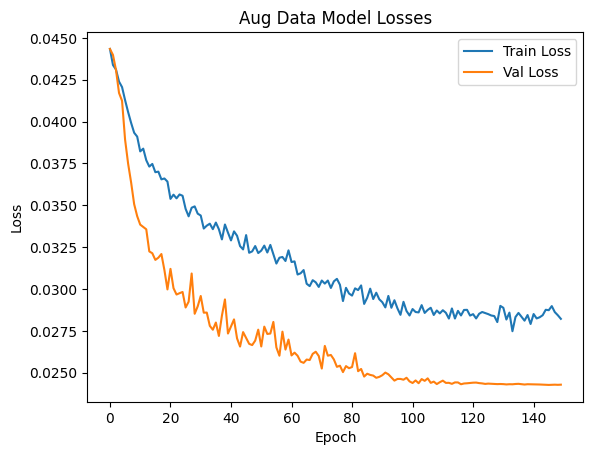

In [232]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Aug Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

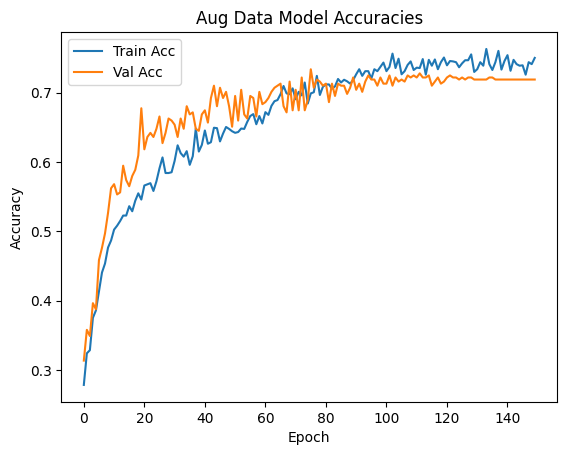

In [233]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Aug Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [241]:
# Load best model and test
aug_model = torch.load("models/cnn/aug.pt")
aug_model.to(device)
aug_model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 40, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Conv2d(40, 48, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (3): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(1, 12), stride=(1, 1), padding=(0, 8), groups=8)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 96, kernel_size=(1, 4), stride=(1, 1), padding=(0, 8), groups=8)
    (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_run

In [242]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on aug data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on aug data, evaluate on raw data
Test Acc: 0.7111


In [243]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.6400


## Train on Sub1 Data

#### Model for Sub1

In [9]:
class CNN_sub(nn.Module):
    def __init__(self):
        super(CNN_sub, self).__init__()

        self.filter_nums1 = 4 # 8
        self.filter_nums2 = 20 # 40
        self.filter_nums3 = 8 # 12
        num_groups = 4
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )
        

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        return x

In [10]:
device = torch.device('mps')

model = CNN_sub()
model = model.to(device)
print(model)
summary(model, input_size=(1, 22, 1000), device='mps')

CNN_sub(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(4, 20, kernel_size=(22, 1), stride=(1, 1), groups=4)
    (1): BatchNorm2d(20, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(20, 20, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=4)
    (1): Conv2d(20, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(8, 4, kernel_size=(1, 31), str

Layer (type:depth-idx)                   Output Shape              Param #
CNN_sub                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 4, 22, 1001]          --
│    └─Conv2d: 2-1                       [1, 4, 22, 1001]          260
│    └─BatchNorm2d: 2-2                  [1, 4, 22, 1001]          8
├─Sequential: 1-2                        [1, 20, 1, 250]           --
│    └─Conv2d: 2-3                       [1, 20, 1, 1001]          460
│    └─BatchNorm2d: 2-4                  [1, 20, 1, 1001]          40
│    └─ELU: 2-5                          [1, 20, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [1, 20, 1, 250]           --
│    └─Dropout: 2-7                      [1, 20, 1, 250]           --
├─Sequential: 1-3                        [1, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [1, 20, 1, 251]           1,620
│    └─Conv2d: 2-9                       [1, 8, 1, 251]            160
│    └─Bat

In [11]:
sub_model = model
sub_model.to(device)

optimizer = torch.optim.Adam(sub_model.parameters(), lr=0.0005,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_sub_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="sub.pt",
    n_epochs=100,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.29batch/s, loss=1.4083]


[Epoch 0] val_acc=0.281065 train_acc=0.246231 val_loss=0.045613 train_loss=0.049502
Validation loss decreased (inf --> 0.045613).  Saving model ...


Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 23.73batch/s, loss=1.3852]


[Epoch 1] val_acc=0.278107 train_acc=0.331658 val_loss=0.045418 train_loss=0.048284
Validation loss decreased (0.045613 --> 0.045418).  Saving model ...


Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 11.84batch/s, loss=1.3460]


[Epoch 2] val_acc=0.275148 train_acc=0.326633 val_loss=0.045318 train_loss=0.047998
Validation loss decreased (0.045418 --> 0.045318).  Saving model ...


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 19.39batch/s, loss=1.3695]


[Epoch 3] val_acc=0.278107 train_acc=0.351759 val_loss=0.045225 train_loss=0.047575
Validation loss decreased (0.045318 --> 0.045225).  Saving model ...


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 19.27batch/s, loss=1.3373]


[Epoch 4] val_acc=0.275148 train_acc=0.402010 val_loss=0.045139 train_loss=0.046151
Validation loss decreased (0.045225 --> 0.045139).  Saving model ...


Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 19.22batch/s, loss=1.4117]


[Epoch 5] val_acc=0.272189 train_acc=0.432161 val_loss=0.045043 train_loss=0.045850
Validation loss decreased (0.045139 --> 0.045043).  Saving model ...


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 15.56batch/s, loss=1.2988]


[Epoch 6] val_acc=0.286982 train_acc=0.472362 val_loss=0.044949 train_loss=0.044917
Validation loss decreased (0.045043 --> 0.044949).  Saving model ...


Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 19.70batch/s, loss=1.1683]


[Epoch 7] val_acc=0.281065 train_acc=0.557789 val_loss=0.044874 train_loss=0.043004
Validation loss decreased (0.044949 --> 0.044874).  Saving model ...


Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 19.24batch/s, loss=1.0714]


[Epoch 8] val_acc=0.260355 train_acc=0.467337 val_loss=0.044806 train_loss=0.043409
Validation loss decreased (0.044874 --> 0.044806).  Saving model ...


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 19.95batch/s, loss=1.1766]


[Epoch 9] val_acc=0.272189 train_acc=0.482412 val_loss=0.044726 train_loss=0.042553
Validation loss decreased (0.044806 --> 0.044726).  Saving model ...


Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 16.71batch/s, loss=1.2241]


[Epoch 10] val_acc=0.272189 train_acc=0.567839 val_loss=0.044645 train_loss=0.042085
Validation loss decreased (0.044726 --> 0.044645).  Saving model ...


Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 16.09batch/s, loss=1.2344]


[Epoch 11] val_acc=0.286982 train_acc=0.532663 val_loss=0.044592 train_loss=0.042348
Validation loss decreased (0.044645 --> 0.044592).  Saving model ...


Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 19.80batch/s, loss=1.3981]


[Epoch 12] val_acc=0.298817 train_acc=0.582915 val_loss=0.044538 train_loss=0.042392
Validation loss decreased (0.044592 --> 0.044538).  Saving model ...


Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 20.11batch/s, loss=1.2251]


[Epoch 13] val_acc=0.319527 train_acc=0.572864 val_loss=0.044490 train_loss=0.040801
Validation loss decreased (0.044538 --> 0.044490).  Saving model ...


Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 16.73batch/s, loss=1.1999]


[Epoch 14] val_acc=0.313609 train_acc=0.628141 val_loss=0.044448 train_loss=0.040270
Validation loss decreased (0.044490 --> 0.044448).  Saving model ...


Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 18.01batch/s, loss=1.2675]


[Epoch 15] val_acc=0.325444 train_acc=0.613065 val_loss=0.044406 train_loss=0.040203
Validation loss decreased (0.044448 --> 0.044406).  Saving model ...


Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 19.91batch/s, loss=1.1630]


[Epoch 16] val_acc=0.331361 train_acc=0.653266 val_loss=0.044364 train_loss=0.039464
Validation loss decreased (0.044406 --> 0.044364).  Saving model ...


Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 18.00batch/s, loss=1.2904]


[Epoch 17] val_acc=0.337278 train_acc=0.648241 val_loss=0.044288 train_loss=0.039446
Validation loss decreased (0.044364 --> 0.044288).  Saving model ...


Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 16.01batch/s, loss=1.0228]


[Epoch 18] val_acc=0.343195 train_acc=0.658291 val_loss=0.044223 train_loss=0.037996
Validation loss decreased (0.044288 --> 0.044223).  Saving model ...


Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 19.89batch/s, loss=0.9534]


[Epoch 19] val_acc=0.355030 train_acc=0.653266 val_loss=0.044218 train_loss=0.037516
Validation loss decreased (0.044223 --> 0.044218).  Saving model ...


Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 20.14batch/s, loss=0.9411]


[Epoch 20] val_acc=0.352071 train_acc=0.623116 val_loss=0.044224 train_loss=0.037459
EarlyStopping counter: 1 out of 30


Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 19.16batch/s, loss=1.0939]


[Epoch 21] val_acc=0.349112 train_acc=0.688442 val_loss=0.044191 train_loss=0.036896
Validation loss decreased (0.044218 --> 0.044191).  Saving model ...


Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 14.75batch/s, loss=0.8965]


[Epoch 22] val_acc=0.363905 train_acc=0.718593 val_loss=0.044104 train_loss=0.035446
Validation loss decreased (0.044191 --> 0.044104).  Saving model ...


Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 12.97batch/s, loss=1.0851]


[Epoch 23] val_acc=0.349112 train_acc=0.733668 val_loss=0.044071 train_loss=0.035730
Validation loss decreased (0.044104 --> 0.044071).  Saving model ...


Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 12.57batch/s, loss=0.9909]


[Epoch 24] val_acc=0.346154 train_acc=0.733668 val_loss=0.044079 train_loss=0.035214
EarlyStopping counter: 1 out of 30


Epoch 25: 100%|██████████| 7/7 [00:00<00:00, 15.29batch/s, loss=1.1069]


[Epoch 25] val_acc=0.355030 train_acc=0.713568 val_loss=0.044058 train_loss=0.035327
Validation loss decreased (0.044071 --> 0.044058).  Saving model ...


Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 17.59batch/s, loss=1.0733]


[Epoch 26] val_acc=0.349112 train_acc=0.723618 val_loss=0.044079 train_loss=0.035357
EarlyStopping counter: 1 out of 30


Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 15.27batch/s, loss=0.7917]


[Epoch 27] val_acc=0.349112 train_acc=0.718593 val_loss=0.044003 train_loss=0.033380
Validation loss decreased (0.044058 --> 0.044003).  Saving model ...


Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 13.02batch/s, loss=0.9862]


[Epoch 28] val_acc=0.360947 train_acc=0.748744 val_loss=0.043980 train_loss=0.034201
Validation loss decreased (0.044003 --> 0.043980).  Saving model ...


Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 11.91batch/s, loss=1.1529]


[Epoch 29] val_acc=0.352071 train_acc=0.768844 val_loss=0.044020 train_loss=0.034201
EarlyStopping counter: 1 out of 30


Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 16.03batch/s, loss=0.9796]


[Epoch 30] val_acc=0.346154 train_acc=0.758794 val_loss=0.044170 train_loss=0.032941
EarlyStopping counter: 2 out of 30


Epoch 31: 100%|██████████| 7/7 [00:00<00:00, 17.95batch/s, loss=0.9503]


[Epoch 31] val_acc=0.366864 train_acc=0.809045 val_loss=0.044150 train_loss=0.032560
EarlyStopping counter: 3 out of 30


Epoch 32: 100%|██████████| 7/7 [00:00<00:00, 15.35batch/s, loss=0.9721]


[Epoch 32] val_acc=0.357988 train_acc=0.748744 val_loss=0.044251 train_loss=0.033496
EarlyStopping counter: 4 out of 30


Epoch 33: 100%|██████████| 7/7 [00:00<00:00, 15.82batch/s, loss=0.7568]


[Epoch 33] val_acc=0.355030 train_acc=0.758794 val_loss=0.044176 train_loss=0.031985
EarlyStopping counter: 5 out of 30


Epoch 34: 100%|██████████| 7/7 [00:00<00:00, 16.49batch/s, loss=1.0634]


[Epoch 34] val_acc=0.363905 train_acc=0.738693 val_loss=0.044252 train_loss=0.032830
EarlyStopping counter: 6 out of 30


Epoch 35: 100%|██████████| 7/7 [00:00<00:00, 20.08batch/s, loss=0.9025]


[Epoch 35] val_acc=0.363905 train_acc=0.839196 val_loss=0.044287 train_loss=0.031374
EarlyStopping counter: 7 out of 30


Epoch 36: 100%|██████████| 7/7 [00:00<00:00, 16.81batch/s, loss=0.9100]


[Epoch 36] val_acc=0.366864 train_acc=0.783920 val_loss=0.044454 train_loss=0.031725
EarlyStopping counter: 8 out of 30


Epoch 37: 100%|██████████| 7/7 [00:00<00:00, 16.50batch/s, loss=0.9152]


[Epoch 37] val_acc=0.363905 train_acc=0.798995 val_loss=0.044492 train_loss=0.030349
EarlyStopping counter: 9 out of 30


Epoch 38: 100%|██████████| 7/7 [00:00<00:00, 18.96batch/s, loss=1.0655]


[Epoch 38] val_acc=0.343195 train_acc=0.814070 val_loss=0.044577 train_loss=0.031641
EarlyStopping counter: 10 out of 30


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 17.35batch/s, loss=1.2282]


[Epoch 39] val_acc=0.343195 train_acc=0.804020 val_loss=0.044763 train_loss=0.031843
EarlyStopping counter: 11 out of 30


Epoch 40: 100%|██████████| 7/7 [00:00<00:00, 16.75batch/s, loss=0.9157]


[Epoch 40] val_acc=0.355030 train_acc=0.793970 val_loss=0.044580 train_loss=0.030536
EarlyStopping counter: 12 out of 30


Epoch 41: 100%|██████████| 7/7 [00:00<00:00, 16.80batch/s, loss=0.7649]


[Epoch 41] val_acc=0.357988 train_acc=0.844221 val_loss=0.044716 train_loss=0.029134
EarlyStopping counter: 13 out of 30


Epoch 42: 100%|██████████| 7/7 [00:00<00:00, 18.91batch/s, loss=0.7608]


[Epoch 42] val_acc=0.355030 train_acc=0.854271 val_loss=0.044937 train_loss=0.028916
EarlyStopping counter: 14 out of 30


Epoch 43: 100%|██████████| 7/7 [00:00<00:00, 18.30batch/s, loss=0.8119]


[Epoch 43] val_acc=0.349112 train_acc=0.864322 val_loss=0.045269 train_loss=0.028500
EarlyStopping counter: 15 out of 30


Epoch 44: 100%|██████████| 7/7 [00:00<00:00, 17.02batch/s, loss=0.8396]


[Epoch 44] val_acc=0.346154 train_acc=0.859296 val_loss=0.045303 train_loss=0.029137
EarlyStopping counter: 16 out of 30


Epoch 45: 100%|██████████| 7/7 [00:00<00:00, 16.16batch/s, loss=1.0851]


[Epoch 45] val_acc=0.352071 train_acc=0.844221 val_loss=0.045517 train_loss=0.029540
EarlyStopping counter: 17 out of 30


Epoch 46: 100%|██████████| 7/7 [00:00<00:00, 18.77batch/s, loss=0.9224]


[Epoch 46] val_acc=0.355030 train_acc=0.824121 val_loss=0.045963 train_loss=0.029333
EarlyStopping counter: 18 out of 30


Epoch 47: 100%|██████████| 7/7 [00:00<00:00, 19.71batch/s, loss=0.6937]


[Epoch 47] val_acc=0.363905 train_acc=0.879397 val_loss=0.046158 train_loss=0.026981
EarlyStopping counter: 19 out of 30


Epoch 48: 100%|██████████| 7/7 [00:00<00:00, 19.88batch/s, loss=0.5772]


[Epoch 48] val_acc=0.355030 train_acc=0.839196 val_loss=0.046182 train_loss=0.028005
EarlyStopping counter: 20 out of 30


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 15.84batch/s, loss=0.7856]


[Epoch 49] val_acc=0.343195 train_acc=0.854271 val_loss=0.046300 train_loss=0.028319
EarlyStopping counter: 21 out of 30


Epoch 50: 100%|██████████| 7/7 [00:00<00:00, 19.33batch/s, loss=0.9311]


[Epoch 50] val_acc=0.355030 train_acc=0.849246 val_loss=0.046449 train_loss=0.028193
EarlyStopping counter: 22 out of 30


Epoch 51: 100%|██████████| 7/7 [00:00<00:00, 19.53batch/s, loss=0.7972]


[Epoch 51] val_acc=0.355030 train_acc=0.854271 val_loss=0.046585 train_loss=0.027187
EarlyStopping counter: 23 out of 30


Epoch 52: 100%|██████████| 7/7 [00:00<00:00, 19.29batch/s, loss=0.7820]


[Epoch 52] val_acc=0.355030 train_acc=0.854271 val_loss=0.046867 train_loss=0.027088
EarlyStopping counter: 24 out of 30


Epoch 53: 100%|██████████| 7/7 [00:00<00:00, 14.22batch/s, loss=0.8187]


[Epoch 53] val_acc=0.369822 train_acc=0.864322 val_loss=0.047029 train_loss=0.027675
EarlyStopping counter: 25 out of 30


Epoch 54: 100%|██████████| 7/7 [00:00<00:00, 18.71batch/s, loss=0.6325]


[Epoch 54] val_acc=0.360947 train_acc=0.889447 val_loss=0.047204 train_loss=0.025759
EarlyStopping counter: 26 out of 30


Epoch 55: 100%|██████████| 7/7 [00:00<00:00, 11.76batch/s, loss=0.8100]


[Epoch 55] val_acc=0.366864 train_acc=0.864322 val_loss=0.047153 train_loss=0.027749
EarlyStopping counter: 27 out of 30


Epoch 56: 100%|██████████| 7/7 [00:00<00:00, 12.26batch/s, loss=0.8475]


[Epoch 56] val_acc=0.360947 train_acc=0.864322 val_loss=0.047093 train_loss=0.027267
EarlyStopping counter: 28 out of 30


Epoch 57: 100%|██████████| 7/7 [00:00<00:00, 18.54batch/s, loss=0.6390]


[Epoch 57] val_acc=0.381657 train_acc=0.869347 val_loss=0.047296 train_loss=0.026441
EarlyStopping counter: 29 out of 30


Epoch 58: 100%|██████████| 7/7 [00:00<00:00, 18.22batch/s, loss=0.6198]


[Epoch 58] val_acc=0.366864 train_acc=0.884422 val_loss=0.047497 train_loss=0.026159
EarlyStopping counter: 30 out of 30
Early stopping.


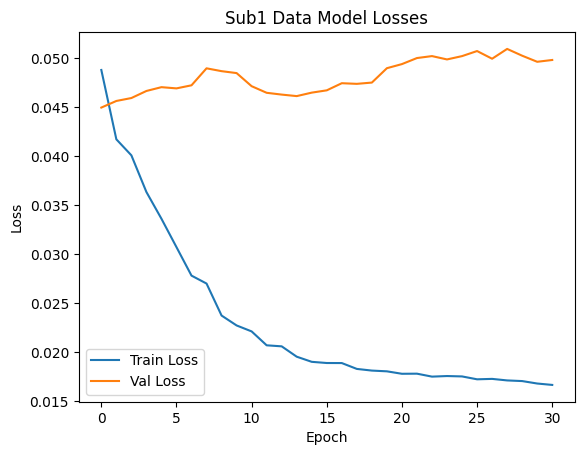

In [10]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

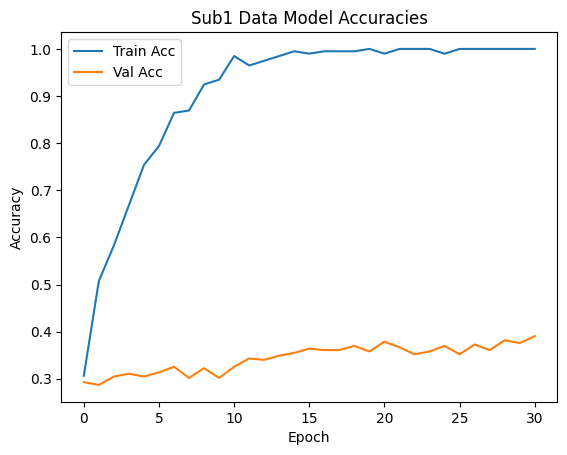

In [11]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [13]:
# Load best model and test
sub1_model = torch.load("models/cnn/sub.pt")
sub1_model.to(device)
sub1_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

In [14]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.2600


## Time Series

In [39]:
class CNN_ts(nn.Module):
    def __init__(self, n_time=1000):
        super(CNN_ts, self).__init__()

        self.filter_nums1 = 24 # 8
        self.filter_nums2 = 120 # 40
        self.filter_nums3 = 32 # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            # nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(4) # the last convolution is replaced by linear
        )
        

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = self.linear(x)

        return x

In [44]:
device = torch.device('mps')

model = CNN_ts(n_time=250)
model = model.to(device)
print(model)
test_input = torch.randn((1, 22, 250)).to(device)
model(test_input).shape
summary(model, input_size=(1, 22, 250), device='mps')

CNN_ts(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
  )
  (linear): Sequential(
    (0): 

Layer (type:depth-idx)                   Output Shape              Param #
CNN_ts                                   [1, 4]                    --
├─Sequential: 1-1                        [1, 24, 22, 251]          --
│    └─Conv2d: 2-1                       [1, 24, 22, 251]          1,560
│    └─BatchNorm2d: 2-2                  [1, 24, 22, 251]          48
├─Sequential: 1-2                        [1, 120, 1, 62]           --
│    └─Conv2d: 2-3                       [1, 120, 1, 251]          8,040
│    └─BatchNorm2d: 2-4                  [1, 120, 1, 251]          240
│    └─ELU: 2-5                          [1, 120, 1, 251]          --
│    └─AvgPool2d: 2-6                    [1, 120, 1, 62]           --
│    └─Dropout: 2-7                      [1, 120, 1, 62]           --
├─Sequential: 1-3                        [1, 32, 1, 7]             --
│    └─Conv2d: 2-8                       [1, 120, 1, 63]           28,920
│    └─Conv2d: 2-9                       [1, 32, 1, 63]            3,840
│

In [45]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [46]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = CNN_ts(n_time=ts)
    time_model.to(device)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=30,
        cp_path="models/cnn",
        cp_filename=f"time_{ts}.pt",
        n_epochs=100,
        show_progress_bar=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/cnn/time_{ts}.pt")
    time_model.to(device)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps
[Epoch 0] val_acc=0.331361 train_acc=0.328081 val_loss=0.024171 train_loss=0.021733
Validation loss decreased (inf --> 0.024171).  Saving model ...
[Epoch 1] val_acc=0.328402 train_acc=0.382667 val_loss=0.024043 train_loss=0.020867
Validation loss decreased (0.024171 --> 0.024043).  Saving model ...
[Epoch 2] val_acc=0.355030 train_acc=0.395611 val_loss=0.023851 train_loss=0.020508
Validation loss decreased (0.024043 --> 0.023851).  Saving model ...
[Epoch 3] val_acc=0.384615 train_acc=0.416432 val_loss=0.023639 train_loss=0.020364
Validation loss decreased (0.023851 --> 0.023639).  Saving model ...
[Epoch 4] val_acc=0.402367 train_acc=0.453573 val_loss=0.023616 train_loss=0.020035
Validation loss decreased (0.023639 --> 0.023616).  Saving model ...
[Epoch 5] val_acc=0.369822 train_acc=0.451322 val_loss=0.023503 train_loss=0.019923
Validation loss decreased (0.023616 --> 0.023503).  Saving model ...
[Epoch 6] val_acc=0.378698 train_acc=0.450760 val_loss=0.023470 train

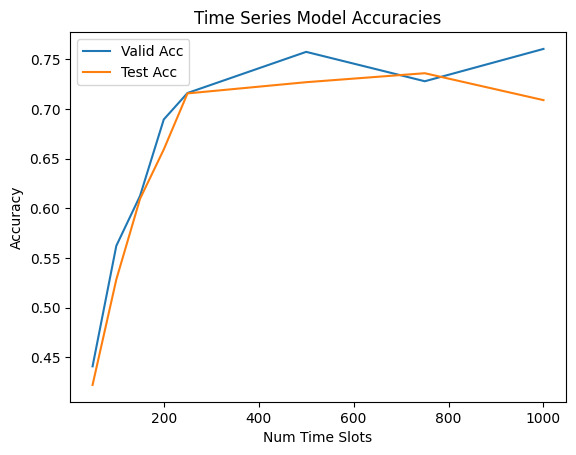

In [47]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()